In [24]:
using Revise
using TaD
using DifferentialEquations, Flux, DiffEqFlux
using Plots
using LinearAlgebra
using SparseArrays
import IJulia
using IterativeSolvers

# Reconstructing Helix in 3D

In [16]:
function create_ūk(Qk::Vector{<:Float64})#, p::Integer = 3, num_samples::Integer = length(Qk) - p - 1) # n = m - p - 1, p = 3 
    """
    According to chord length method defined on pg 364
    """
    Qk_copy = copy(Qk)
    Qk_shift = copy(Qk)
    popfirst!(Qk_shift)
    pop!(Qk_copy)
    ūk = cumsum(broadcast(abs, Qk_shift - Qk_copy)) / sum(broadcast(abs, Qk_shift - Qk_copy))
    insert!(ūk, 1, 0)
    ūk
end

function create_knot_vector_new(Qk::Vector{<:Float64}, p::Integer = 3)
    ū = create_ūk(Qk)
    m = length(Qk)
    kv = zeros(m)
    n = m - p - 1
    d = (m + 1) / (n - p + 1)
    for j = 2:(n - p)
        i = floor(Int, j * d)
        α = j * d - i
        kv[j + p] = (1 - α) * ū[i - 1] + α * ū[i]
    end
    kv[(end - p):end] .= 1
    kv#, ū
end

function generate_helix_test_tangents(
    r::Real = 1,
    c::Real = 1,
    number_of_points::Integer = 100,
)
    t = LinRange(0, 1, number_of_points)
    theta = LinRange(0, 100, number_of_points)
    dx = r .* cos.(theta)
    dy = r .* sin.(theta)
    dz = c
    arr = zeros(Float64, (length(t), 3))
    arr[:, 1] = dx
    arr[:, 2] = dy
    arr[:, 3] = c * t
    arr
end

function pow(x,y=2)
    return x^y
end

function generate_test_set((f1, f2), num::Integer = 100)
    t = LinRange(0, 1, num+1)
    dx = f1.(t)
    dy = f2.(t)
    dz = 1
    arr = zeros(Float64, (length(t), 3))
    arr[:, 1] = dx
    arr[:, 2] = dy
    arr[:, 3] = dz * t
    arr
end

generate_test_set (generic function with 2 methods)

# Trajectory Reconstruct 

In [17]:
#Knots = m
#From definition, m = n + p + 1
#set m = length(tangents) so the linear algebra works out
#then set n (num samples) = m - p - 1
function reconstruct_trajectory(tangents::Matrix{<:Float64}, number_of_control_points::Integer=(length(tangents) ÷ 2))
    control_points = similar(tangents)
    control_points[:,1] = reconstruct_trajectory_1d(tangents[:,1])
    control_points[:,2] = reconstruct_trajectory_1d(tangents[:,2])
    control_points[:,3] = tangents[:,3]
    kv = create_knot_vector_new(tangents[:,1])
    basis = BSplineBasis(kv, 3, k=2)
    curve = BSplineCurve(basis, control_points)
    return curve
end

function return_zero_rows(A)
    row_zeros = mapslices(is_row_zero, A, dims=[1]).*cumsum(ones(size(A, 1)))'
    row_zeros = row_zeros[row_zeros .> 0]
    return row_zeros
end

function is_row_zero(A)
    if sum(A[A .!= 0]) == 0
        return true
    end
    return false
end

function reconstruct_trajectory_1d(tangents::Vector{<:Float64}, number_of_control_points::Integer=(length(tangents) ÷ 2))
    kv = create_knot_vector_new(tangents)
    ū = create_ūk(tangents) # n = m - p - 1
    basis = BSplineBasis(kv, 3, k=2)
    N, Nprime = construct_spline_matrix(basis, ū, length(kv))
    T = Nprime'*Nprime
    print("\n", return_zero_rows(T))
    A = pinv(Nprime' * Nprime)
    B = (Nprime' * tangents)
    control_points = A*B #N*(A*B)#idrs(Nprime, tangents), Nprime*idrs(Nprime, tangents)#
end

function construct_spline_matrix(basis::BSplineBasis, samples::Vector{<:Float64}, num_knots::Integer)
    rows, cols = length(samples), num_knots
    N, Nprime = zeros(Float64, (rows, cols)), zeros(Float64, (rows, cols))
    N[1, 1] = 1
    N[2, 1] = 1
    Nprime[1, 1] = 1
    Nprime[2, 1] = 1
    for i in 3:1:rows-1
        evals = basis(samples[i])
        N[i,find_knot_span(basis, samples[i])-2:find_knot_span(basis, samples[i])+1] =evals[1,:]
        Nprime[i,find_knot_span(basis, samples[i])-2:find_knot_span(basis, samples[i])+1] = evals[2,:]
        #N[i,i-2:i+1] =evals[1,:]
        #Nprime[i,i-2:i+1] = evals[2,:]
    end
    N, Nprime
end

construct_spline_matrix (generic function with 1 method)


[2.0, 23.0, 24.0, 25.0]
[2.0, 3.0, 21.0, 23.0, 24.0, 25.0]
default range 

here
range(0.041666666666666664, stop=0.8333333333333334, length=100)
 end of function 


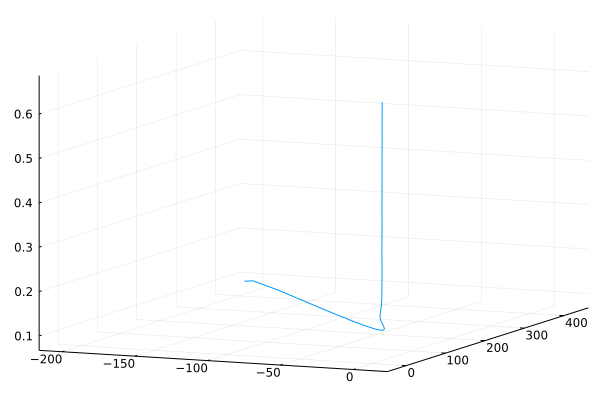

In [23]:
p = 3
Q = #generate_test_set((pow, pow), 1000)
Q = generate_helix_test_tangents(1, 1, 25)
#Q = round.(Q, digits=10)
T = generate_test_set((pow, pow), 100)#generate_helix_test_tangents(1, 1, 1000)generate_helix_test_tangents(1, 1, 1000)

curve1 = reconstruct_trajectory(Q)
plot(curve1)
#plot((Q[:,1], Q[:,2], Q[:,3]))

In [ ]:
function WCLeastSquares(Qk::Vector{<:Float64}, Wq::Vector{<:Int64}, Dk::Vector{<:Float64}, Wd::Vector{<:Int64}, p::Integer = 3, n::Int64 = Int(length(Qk)) - p)
    """
    Weighted and Constrained Least Squares Curve Fit
    Qk: Points to be fit, Wq: Weights. Wq < 0 Means constrained point. Either 1 or -1
    Dk: Points to be fit, Wd: Weights. Wd < 0 Means constrained point. Either 1 or -1
    """
    mu = sum(Wq[Wq .> 0]) + sum(Wd[Wd .> 0])
    mc = abs(sum(Wq[Wq .< 0])) + abs(sum(Wd[Wd .< 0]))
    r = length(Qk)
    if (mc >= n || mc + n > mu+1)
        throw(AssertionError("Too many constrained points, mc: $mc, n: $n, mu: $mu, \n"))
    end
    uk = create_ūk(Qk)
    kv = create_knot_vector_new(Qk)
    print(size(kv))
    basis = BSplineBasis(kv, p, k=3)
    N, Nprime, M, Mprime = zeros(mu+1, n+1), zeros(mu+1, n+1), zeros(mc+1, n+1), zeros(mc+1, n+1)
    S, T = zeros(mu+1), zeros(mc+1)
    A = zeros(mc+1) #lagrange multipliers
    mu2, mc2 = 0, 0
    for i in 1:n
        if Wq[i] > 0 #Unconstrained
            mu2 += 1
            eval = uk[mu2]
            S[mu2] = Wq[i] * Qk[i]
            Nevals = basis(eval)
            N[mu2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Nevals[1,:]
            Nprime[mu2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Nevals[2,:]
        else
            mc2 += 1 #Constrained
            eval = uk[mc2]
            T[mc2] = Qk[i]
            Mevals = basis(uk[mc2])
            M[mc2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Mevals[1,:]
            Mprime[mc2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Mevals[2,:]

        end
        if i < length(Wd)
            if Wd[i] > 0 #Unconstrained
                mu2 += 1            
                eval = uk[mu2]
                S[mu2] = Wd[i] * Dk[i]
                Nevals = basis(uk[mu2])
                N[mu2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Nevals[2,:]
            else
                mc2 += 1 #Constrained
                eval = uk[mc2]
                T[mc2] = Dk[i]
                Mevals = basis(uk[mc2])
                M[mc2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Mevals[2,:]

            end
        end
    end
    if mc == 0
        P = inv(Nprime'*Nprime)*(Nprime'*S)
        return P
    end
    inverted = pinv(Nprime'*Nprime) #cant compute LU Decomposition, can't invert. 
    G = pinv(Mprime*inverted*Mprime')
    F = (Mprime*inverted*Nprime'*S - T)
    A = G*F
    P = pinv(N'*N)*((N'*S) - M'*A)
    return P, basis, kv, N, Nprime
end

# WCLeastSquares Test

In [ ]:
p = 3
Q = #generate_test_set((pow, pow), 1000)
Q = generate_helix_test_tangents(1, 1, 1000)
T = generate_test_set((pow, pow), 1000)#generate_helix_test_tangents(1, 1, 1000)generate_helix_test_tangents(1, 1, 1000)
Wq = ones(Int64, length(Q[:,1]))
Wd = ones(Int64, 1).*-1
#Wq[1] = -1
#Wq[end] = -1
#Wq[end] = -1
P1, basis, kv, N1, N1prime = WCLeastSquares(Q[:,1], Wq, T[:,1], Wd, p, Int(length(Q[:,1]) - 4))
P2, basis, kv, N2, N2prime = WCLeastSquares(Q[:,2], Wq, T[:,1], Wd, p, Int(length(Q[:,2])  - 4))
#P3 = WCLeastSquares(Q[:,3], Wq, T[:,3], Wd, Int(length(Q[:,3])/2))
Points = hcat(collect((1. / length(P1)):(1. / length(P1)):1), P1, P2)
basis = BSplineBasis(kv, 3, k=2)
Curve = BSplineCurve(basis, Points)
plot(Curve)
#plot(N1*P1, N2*P2, collect(1:1:length(P1)+p))

In [ ]:
plot(Curve.control_points)

In [ ]:
function default_range(c::BSplineCurve, num::Integer=100)
    p = c.basis.order
    print("\ndefault range \n")
    start = c.control_points[1]
    stop = c.control_points[end - p - 1]
    #print("start: ", start, "\n")
    #print("stop: ", stop, "\n")
    LinRange(start, stop, num)
end

x = default_range(curve1)
print("control points: ", curve1.control_points, "\n")
print(x)
curve = zeros(Float64, (length(x), size(curve1.control_points)[2]))


# @series begin
# seriestype := :path 
# primary := false
# linecolor := :lightgray
# markercolor := :red
# markershape := :circle
# tuple(eachcol(c.control_points)...)
# end

#print(curve1(.01)[1,:])
for (j, u) in enumerate(x)
    #print("\n u: ", u, "\n")
    curve[j, :] = curve1(u)[1, :] 
end
print("\n end of function \n")

tuple(eachcol(curve)...)

In [ ]:
Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,1]
Uk = create_ūk(Q)
Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,1]
print("Dims Uk, Dims Q: ", length(Uk)," ", length(Q), "\n")
kv = create_knot_vector_new(Q)
N = zeros(length(Uk), length(kv))
basis = BSplineBasis(kv, 3, k=3)
#print("kv: ", kv, "\n")
#print("Uk: ", Uk, "\n")
cnt = 0
for eval in Uk
    cnt=cnt+1
    evals = basis(eval)
    N[cnt, (find_knot_span(basis, eval)-2):(find_knot_span(basis, eval)+1)] = evals[2,:]
end
control_points = pinv(N'*N, rtol = sqrt(eps(real(float(one(eltype(N'*N)))))))*N'*Q
print("DIms: ", size(control_points), size(control_points), size(collect(0:.001:1.002)))
cps = hcat(control_points, control_points, collect(0:.001:1.002))

Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,2]
Uk = create_ūk(Q)
Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,2]
print("Dims Uk, Dims Q: ", length(Uk)," ", length(Q), "\n")
kv = create_knot_vector_new(Q)
N = zeros(length(Uk), length(kv))
basis = BSplineBasis(kv, 3, k=3)
#print("kv: ", kv, "\n")
#print("Uk: ", Uk, "\n")
cnt = 0
for eval in Uk
    cnt=cnt+1
    evals = basis(eval)
    N[cnt, (find_knot_span(basis, eval)-2):(find_knot_span(basis, eval)+1)] = evals[2,:]
end
control_points = pinv(N'*N, rtol = sqrt(eps(real(float(one(eltype(N'*N)))))))*N'*Q
cps[:,2] = control_points
#print("Control Points: ", cps)
Curve = BSplineCurve(basis, cps)
#print("Dims N*cps, cps[:,3]: ", size(N*cps[:,1]), size(cps[:,3]))
#tangents = [N*cps[:,1] N*cps[:,2] cps[:,3]]
#print(size(tangents))
Q = generate_helix_test_tangents(1, 1, 1000)
Q1 = copy(Q[:,1])
pop!(Q1)
print(size(Q1))
#plot((tangents[:,1],tangents[:,2], tangents[:,3]))
plot(Curve, k=0)

In [ ]:
plot((arr[:,3], arr[:,1], arr[:,2]))